In [35]:
import pandas as pd
from datetime import datetime
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [2]:
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

In [5]:
data = pd.read_csv('../Data/data.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)

In [6]:
data.head()

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [8]:
data.drop('No', axis=1, inplace=True)

In [10]:
data.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']

In [12]:
data.index.name = 'date'

In [14]:
data['pollution'].fillna(0, inplace=True)

In [15]:
data.shape

(43824, 8)

In [17]:
data.tail()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0
2014-12-31 22:00:00,8.0,-22,-4.0,1034.0,NW,246.72,0,0
2014-12-31 23:00:00,12.0,-21,-3.0,1034.0,NW,249.85,0,0


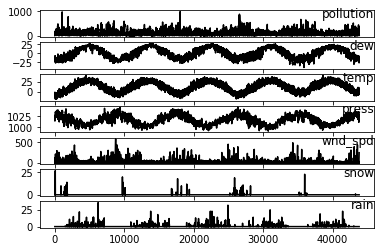

In [21]:
values = data.values
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group],'k')
	plt.title(data.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [28]:
def s_to_super(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [31]:
values = data.values
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = s_to_super(scaled, 1, 1)

In [32]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)


In [33]:
# split data into training and testing, futher splitting the train and test sets into i/p and o/p variables
# reshaped data further into 3D formate expected by LSTMs
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [34]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [36]:
# defining LSTM with 50 neurons in first hidden layer and 1 neuron in the o/p layer
# using the MAE loss function and Adam version of stochastic gradient descent
model = Sequential()

In [37]:
# 50 neurons in first hidden layer
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(1,kernel_initializer='normal', activation='sigmoid'))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

W0810 11:35:45.322399 12008 deprecation.py:506] From c:\users\0x6f736f646f\documents\keras\keras\backend\tensorflow_backend.py:3721: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 8760 samples, validate on 35063 samples
Epoch 1/50
 - 8s - loss: 0.3018 - val_loss: 0.1372
Epoch 2/50
 - 2s - loss: 0.0943 - val_loss: 0.0750
Epoch 3/50
 - 2s - loss: 0.0760 - val_loss: 0.0713
Epoch 4/50
 - 2s - loss: 0.0733 - val_loss: 0.0686
Epoch 5/50
 - 2s - loss: 0.0697 - val_loss: 0.0657
Epoch 6/50
 - 2s - loss: 0.0655 - val_loss: 0.0622
Epoch 7/50
 - 2s - loss: 0.0597 - val_loss: 0.0577
Epoch 8/50
 - 2s - loss: 0.0539 - val_loss: 0.0534
Epoch 9/50
 - 2s - loss: 0.0482 - val_loss: 0.0508
Epoch 10/50
 - 2s - loss: 0.0437 - val_loss: 0.0473
Epoch 11/50
 - 2s - loss: 0.0401 - val_loss: 0.0449
Epoch 12/50
 - 2s - loss: 0.0377 - val_loss: 0.0409
Epoch 13/50
 - 2s - loss: 0.0357 - val_loss: 0.0382
Epoch 14/50
 - 2s - loss: 0.0348 - val_loss: 0.0361
Epoch 15/50
 - 2s - loss: 0.0334 - val_loss: 0.0340
Epoch 16/50
 - 2s - loss: 0.0330 - val_loss: 0.0324
Epoch 17/50
 - 2s - loss: 0.0320 - val_loss: 0.0311
Epoch 18/50
 - 2s - loss: 0.0319 - val_loss: 0.0300
Epoch 19/50
 - 2s - loss

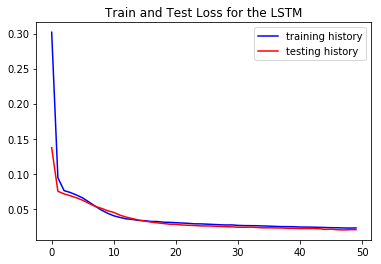

In [38]:
# tracking history for plots
plt.plot(history.history['loss'], 'b', label='training history')
plt.plot(history.history['val_loss'],  'r',label='testing history')
plt.title("Train and Test Loss for the LSTM")
plt.legend()
plt.show()

In [39]:
# evaluating model
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
inv_y = scaler.inverse_transform(test_X)
inv_y = inv_y[:,0]

In [40]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 19.598
